In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm

In [ ]:
# !pip install catboost

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# %cd /content/gdrive/My Drive/Classroom/GP2/data
data_description = "house_prices_data_description.txt"
sample_submission = "house_prices_sample_submission.csv"
test_csv = "house_prices_test.csv"
train_csv = "house_prices_train.csv"

In [ ]:
df_train = pd.read_csv(train_csv, sep = ',')
df_test = pd.read_csv(test_csv, sep = ',')


In [ ]:
# (df_test["MSZoning"] - df_train["MSZoning"].min(axis=0)) / (df_train["MSZoning"].max(axis=0) - df_train["MSZoning"].min(axis=0))
df_train.MSZoning.unique(), df_test.MSZoning.unique()

(array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object),
 array(['RH', 'RL', 'RM', 'FV', 'C (all)', nan], dtype=object))

In [ ]:
df_train.drop(columns=["SalePrice"]).drop_duplicates()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal


In [ ]:
# Парсинг файла data_description
def parse_data_description(file):
    with open(file) as f:
        lines = f.readlines()
    
    # Словарь из параметр: список значений
    params_values_dict = {} 
    for line in lines:
        words = line.split()

        if words:
            word1 = words[0]
        else:
            continue

        if ':' in word1:
            param = word1[:-1]
            vals = []
            params_values_dict[param] = vals
        else:
            words = line.split("\t")
            word1 = words[0].strip()

            if word1.strip() == "NA":
                word1 = "NA=" + " ".join(words[1:])
                word1 = word1.replace('\n', '')
            
            # Скорректируем тип для числовых значений
            if param in ['MSSubClass', 'OverallQual', 'OverallCond']:
                word1 = int(word1)
                         
            # Скорректируем опечатки                 
            if param == 'BldgType':
                if word1 == 'Duplx':
                    word1 = 'Duplex'
                if word1 == '2FmCon':
                    word1 = '2fmCon'
            
            if param == 'Neighborhood':
                if word1 == 'Names':
                    word1 = 'NAmes' 
    
            vals.append(word1)

    # удалим параметры, у которых нет значений
    to_del = []
    for param in params_values_dict:
        if not params_values_dict[param]:
            to_del.append(param)

    for param in to_del:
        del params_values_dict[param]
        
    return params_values_dict

descriptions_values = parse_data_description(data_description)
descriptions_values

{'MSSubClass': [20,
  30,
  40,
  45,
  50,
  60,
  70,
  75,
  80,
  85,
  90,
  120,
  150,
  160,
  180,
  190],
 'MSZoning': ['A', 'C', 'FV', 'I', 'RH', 'RL', 'RP', 'RM'],
 'Street': ['Grvl', 'Pave'],
 'Alley': ['Grvl', 'Pave', 'NA=No alley access'],
 'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'],
 'LandContour': ['Lvl', 'Bnk', 'HLS', 'Low'],
 'Utilities': ['AllPub', 'NoSewr', 'NoSeWa', 'ELO'],
 'LotConfig': ['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3'],
 'LandSlope': ['Gtl', 'Mod', 'Sev'],
 'Neighborhood': ['Blmngtn',
  'Blueste',
  'BrDale',
  'BrkSide',
  'ClearCr',
  'CollgCr',
  'Crawfor',
  'Edwards',
  'Gilbert',
  'IDOTRR',
  'MeadowV',
  'Mitchel',
  'NAmes',
  'NoRidge',
  'NPkVill',
  'NridgHt',
  'NWAmes',
  'OldTown',
  'SWISU',
  'Sawyer',
  'SawyerW',
  'Somerst',
  'StoneBr',
  'Timber',
  'Veenker'],
 'Condition1': ['Artery',
  'Feedr',
  'Norm',
  'RRNn',
  'RRAn',
  'PosN',
  'PosA',
  'RRNe',
  'RRAe'],
 'Condition2': ['Artery',
  'Feedr',
  'Norm',
  'RRNn',
  'RRAn

# Part 1: Exploratory Data Analysis

 ## 1.1 Get a first overview of the train and test dataset:

In [ ]:
df_train.shape,df_test.shape

((1460, 81), (1459, 80))

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [ ]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
#save the 'Id' column
train_ID = df_train['Id']
test_ID = df_test['Id']

#drop the  'Id' colum since it's unnecessary for  the prediction process.
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

*df train has 81 columns (80 features and target SalePrice) and 1460 entries. 
For some features many values are missing. For example, there are only 7 values for Pool QC.*

## 1.2 Have a look at the target column:

In [ ]:
#descriptive statistics summary
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


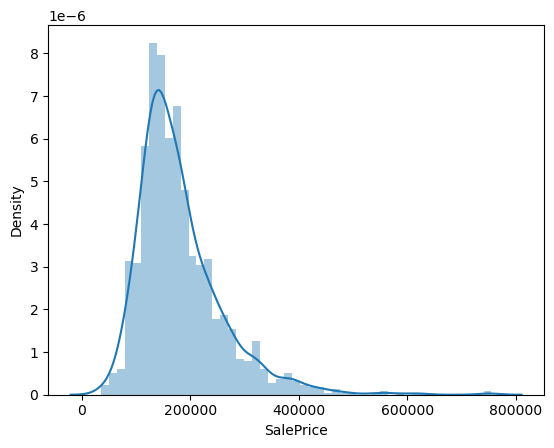

In [ ]:
#histogram
sns.distplot(df_train['SalePrice']);

*As we see, the target variable SalePrice is not quite normally distributed.Therfore, we make a log transformation since some ML regression models assume normal distribution*

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


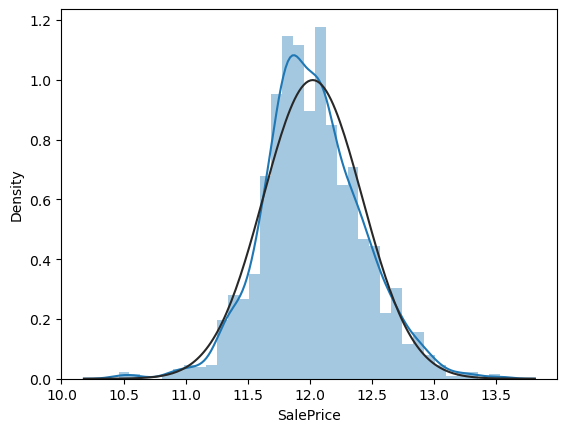

In [ ]:
#log transformation
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])
sns.distplot(df_train['SalePrice'], fit=norm);

## 1.3 Bi-variate analysis

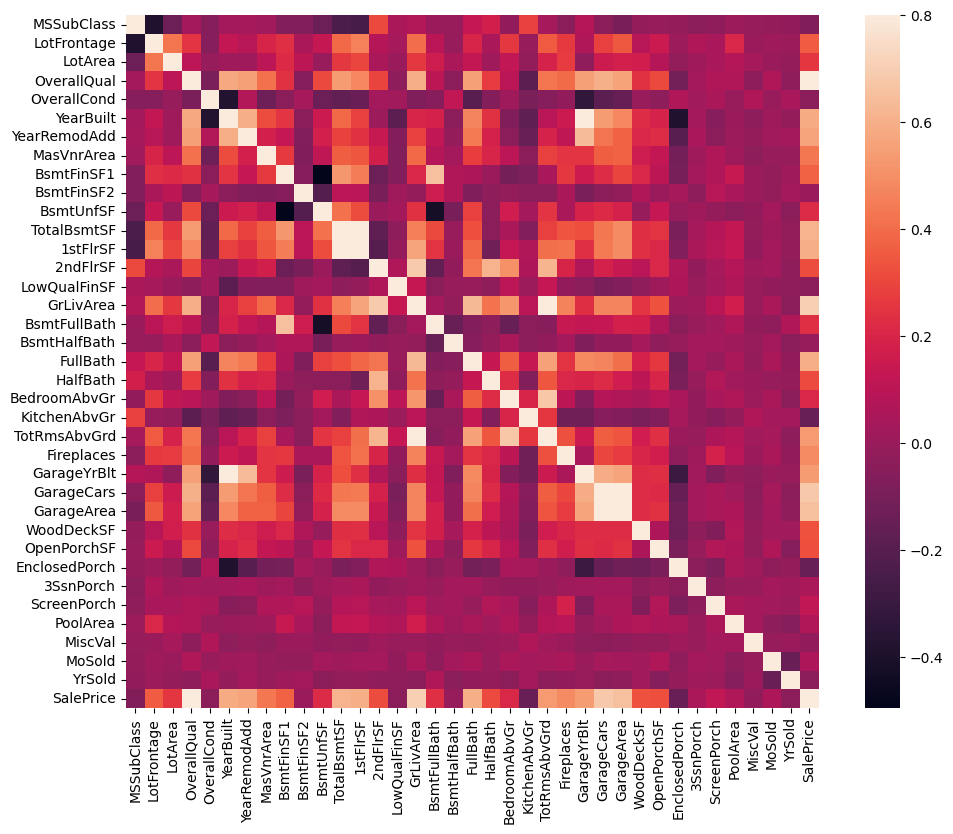

In [ ]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

<AxesSubplot:>

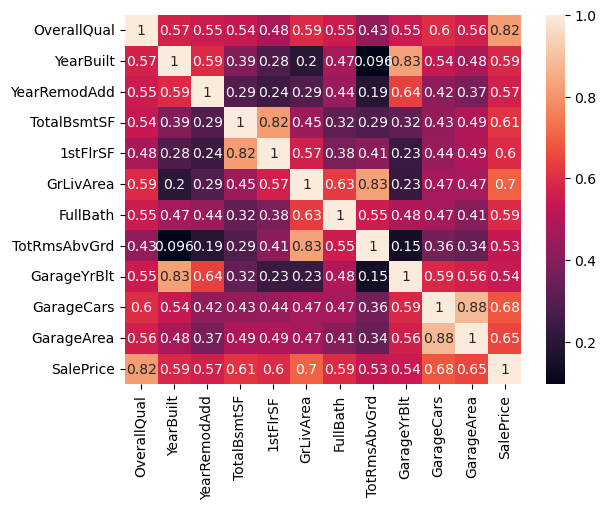

In [ ]:
highest_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
#plt.figure(figsize=(10,10))
sns.heatmap(df_train[highest_corr_features].corr(),annot=True)

In [ ]:
highest_corr_features

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'SalePrice'],
      dtype='object')

Highly Correlated with SalePrice variables:
- OverallQual
- GrLivArea
- GarageCars or GarageArea
- TotalBsmtSF 

Highly Correlated between each other variables:

- GarageYrBlt and YearBuilt \
- TotRmsAbvGrd and GrLivArea \
- 1stFlrSF and TotalBsmtSF \
- GarageArea and GarageCars

In [ ]:
corrmat["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
GarageYrBlt      0.541073
TotRmsAbvGrd     0.534422
Fireplaces       0.489450
MasVnrArea       0.430809
BsmtFinSF1       0.372023
LotFrontage      0.355879
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
Name: SalePrice, dtype: float64

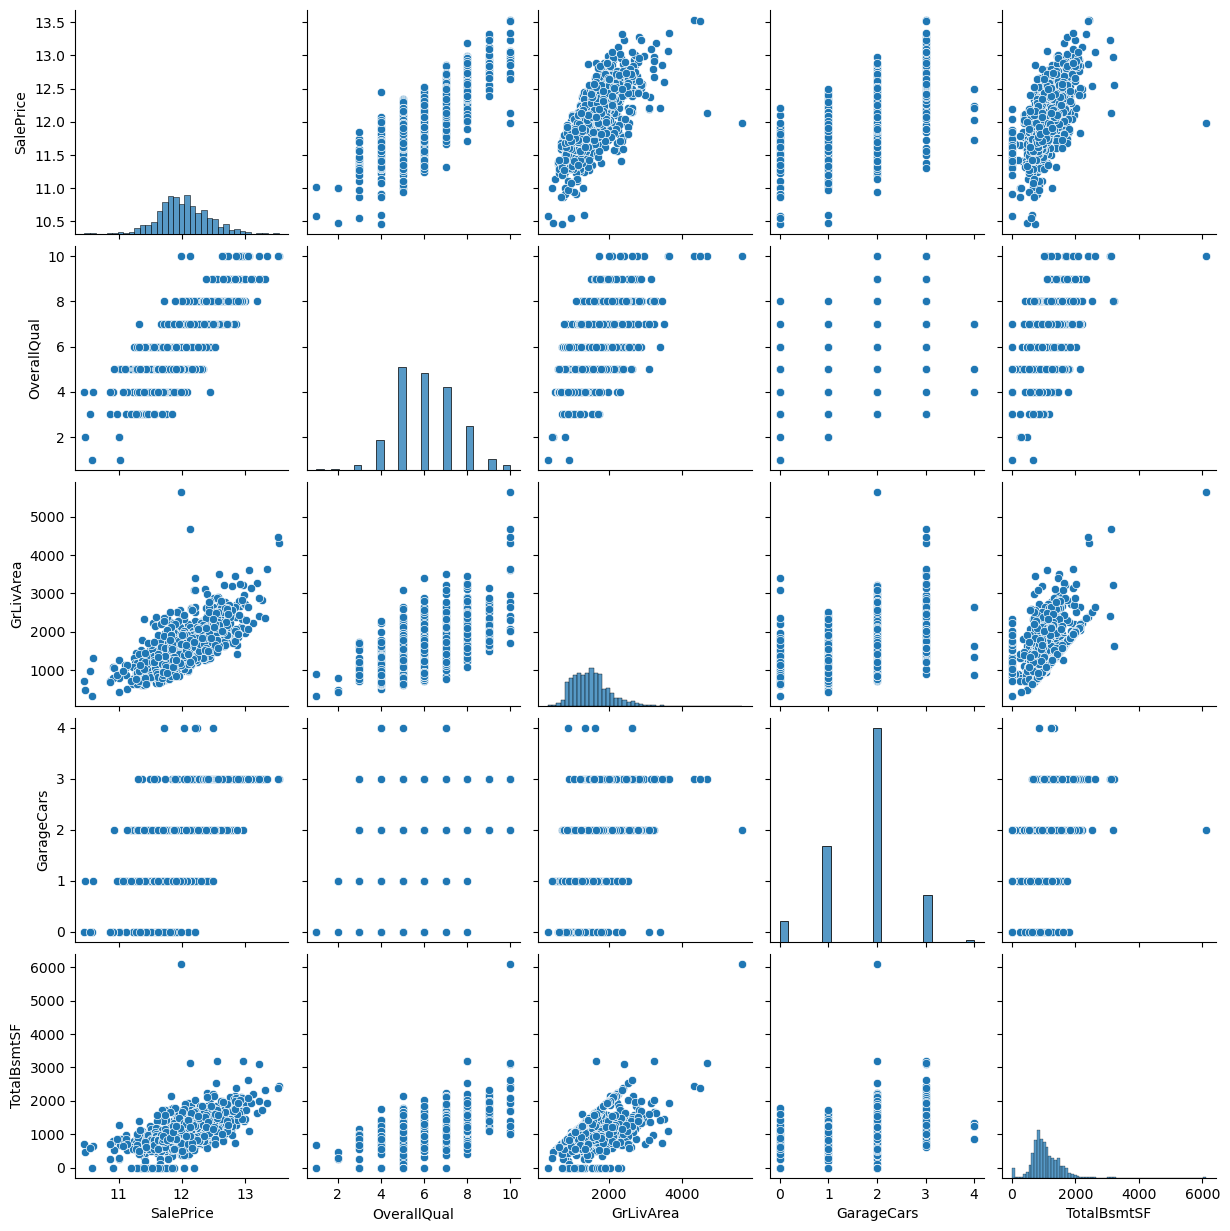

In [ ]:
#scatterplot
corr_features = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF']
sns.pairplot(df_train[corr_features])


## 1.4 Numeric and categorial features



In [ ]:
numerical = df_train.dtypes[df_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical))

categorical = df_train.dtypes[df_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical))

print(df_train[numerical].columns)
print()
print(df_train[categorical].columns)


Number of Numerical features:  37
Number of Categorical features:  43
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'B

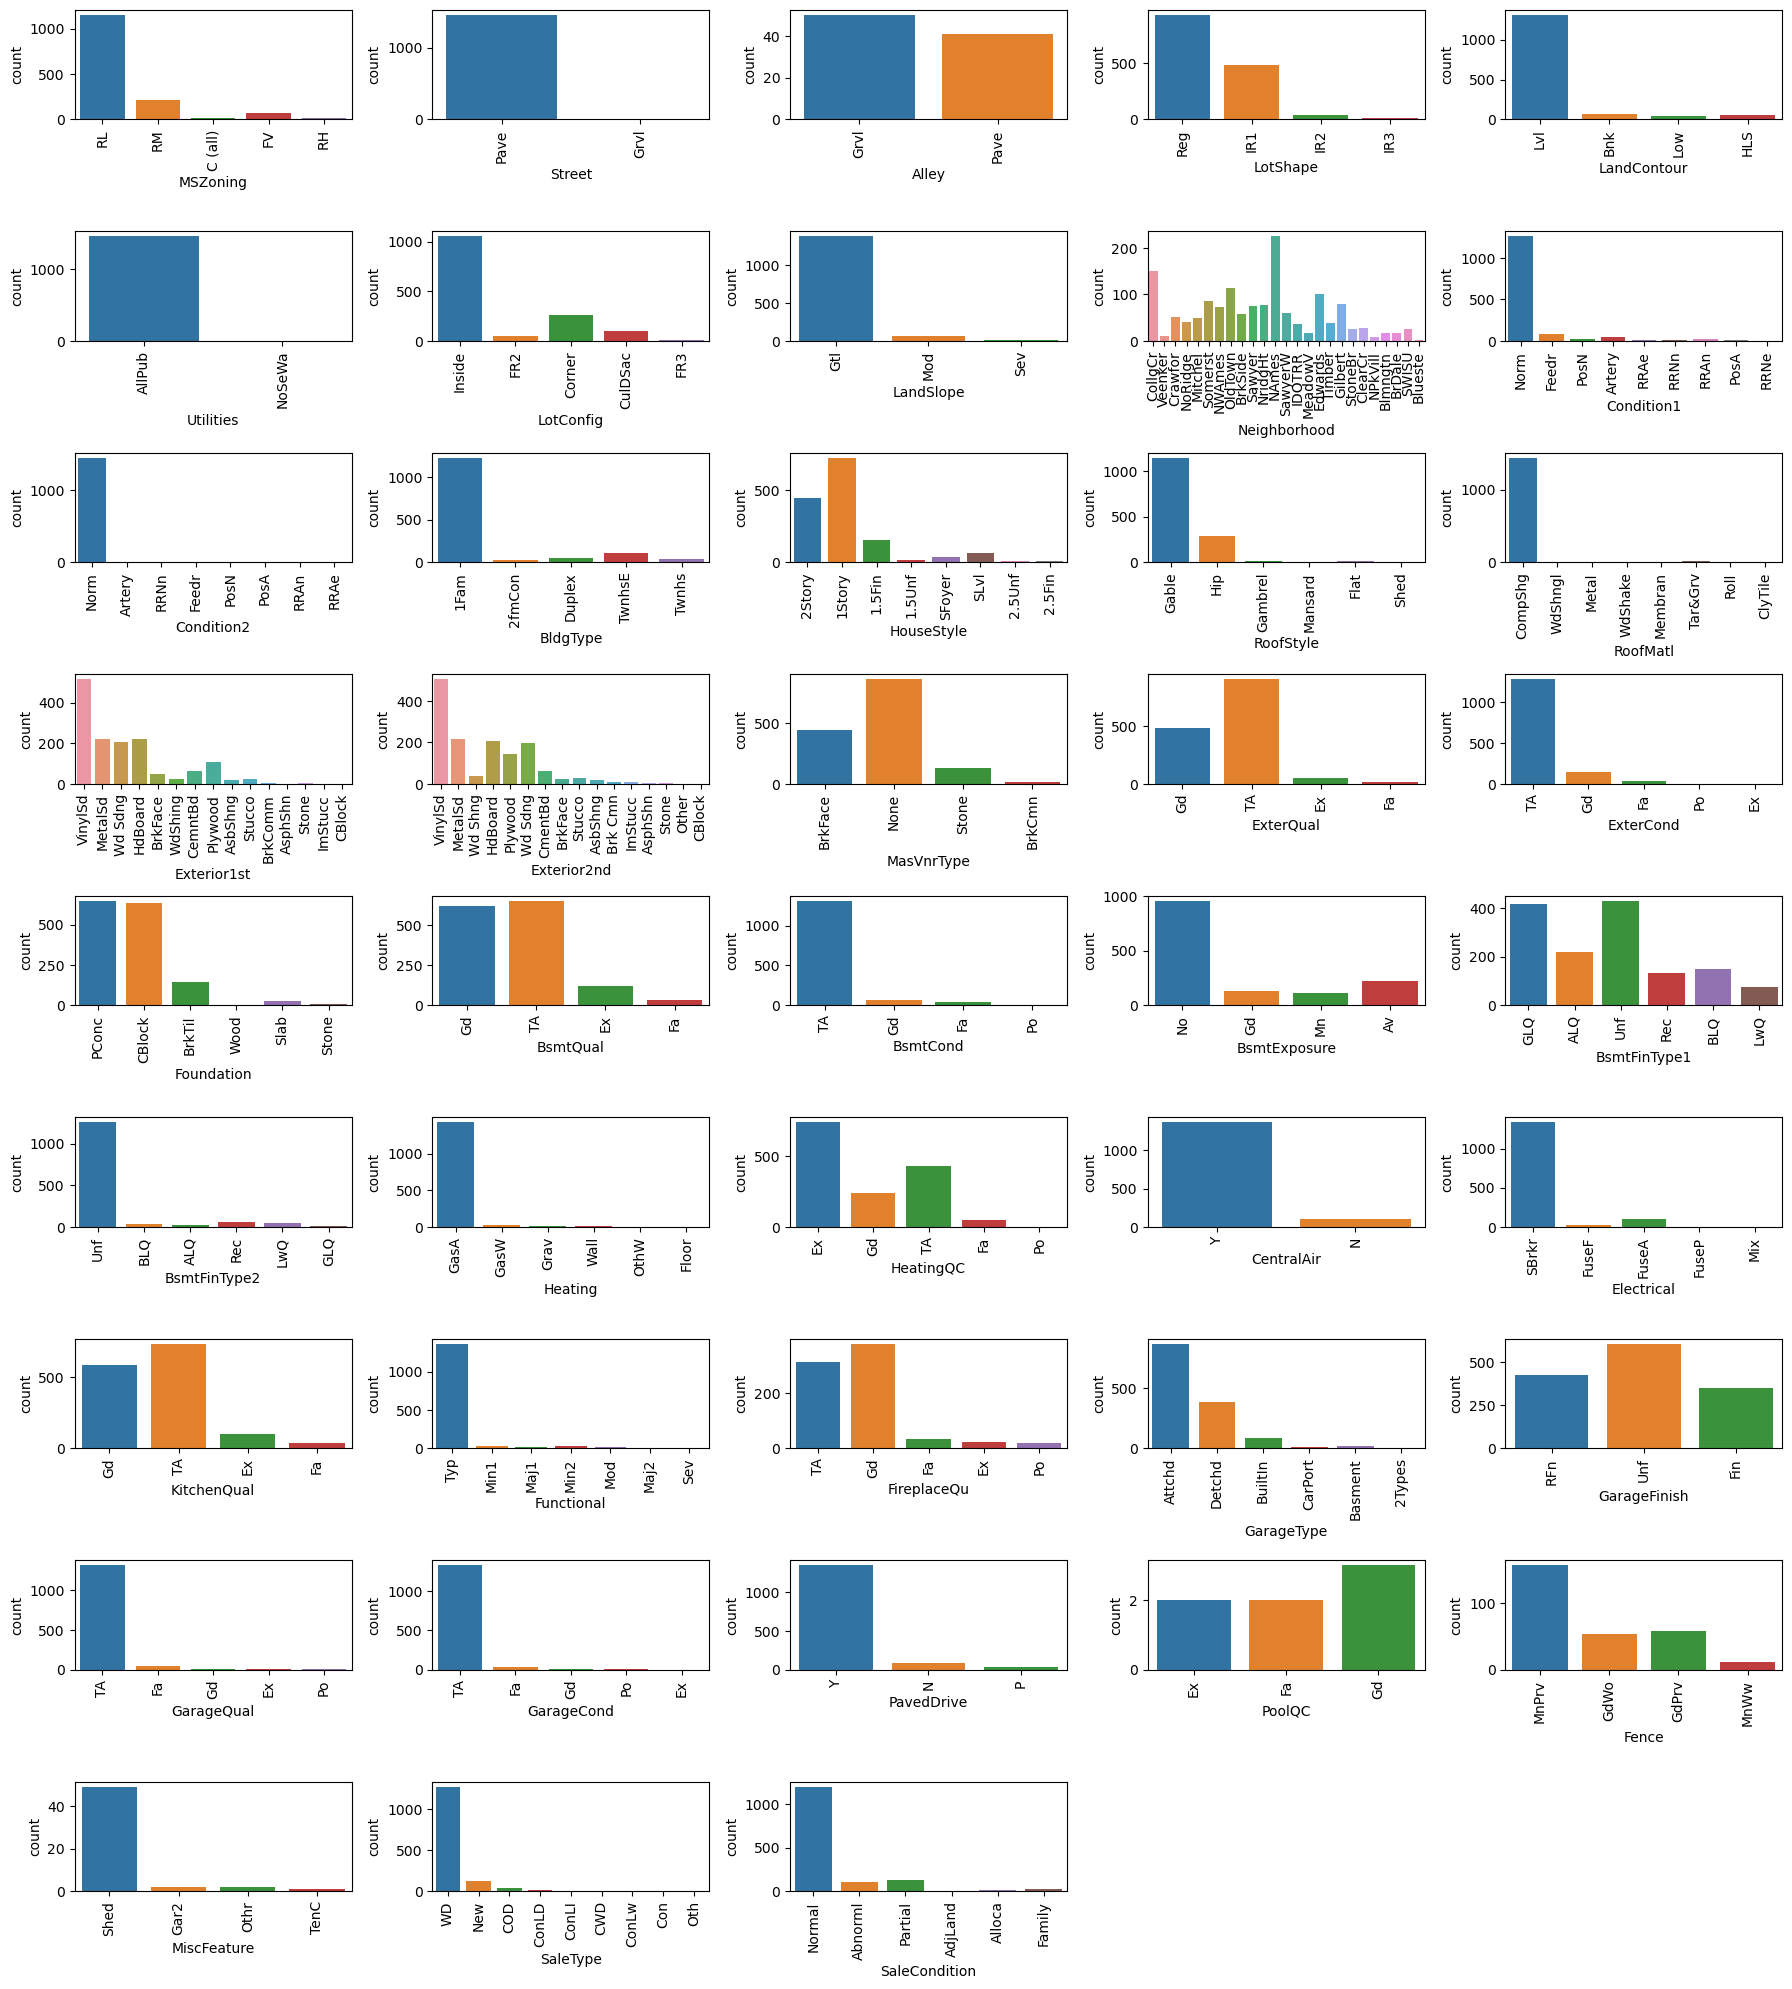

In [ ]:
fig = plt.figure(figsize=(18,20))
for index in range(len(categorical)):
    plt.subplot(9,5,index+1)
    sns.countplot(x=df_train[categorical].iloc[:,index], data=df_train[categorical].dropna())
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)



In [ ]:
# fig = plt.figure(figsize=(18,20))
# for index in range(len(numerical)):
#     plt.subplot(9,5,index+1)
#     sns.countplot(x=df_train[numerical].iloc[:,index], data=df_train[numerical].dropna())
#     plt.xticks(rotation=90)
# fig.tight_layout(pad=1.0)



*We can see that some features mostly consist of just a single value or 0s, which is not useful to us. Therefore, we will remove them.*

In [ ]:
numerical_disc = ['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']

numerical_cont = []
for i in df_train[numerical].columns:
    if i not in numerical_disc:
        numerical_cont.append(i)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


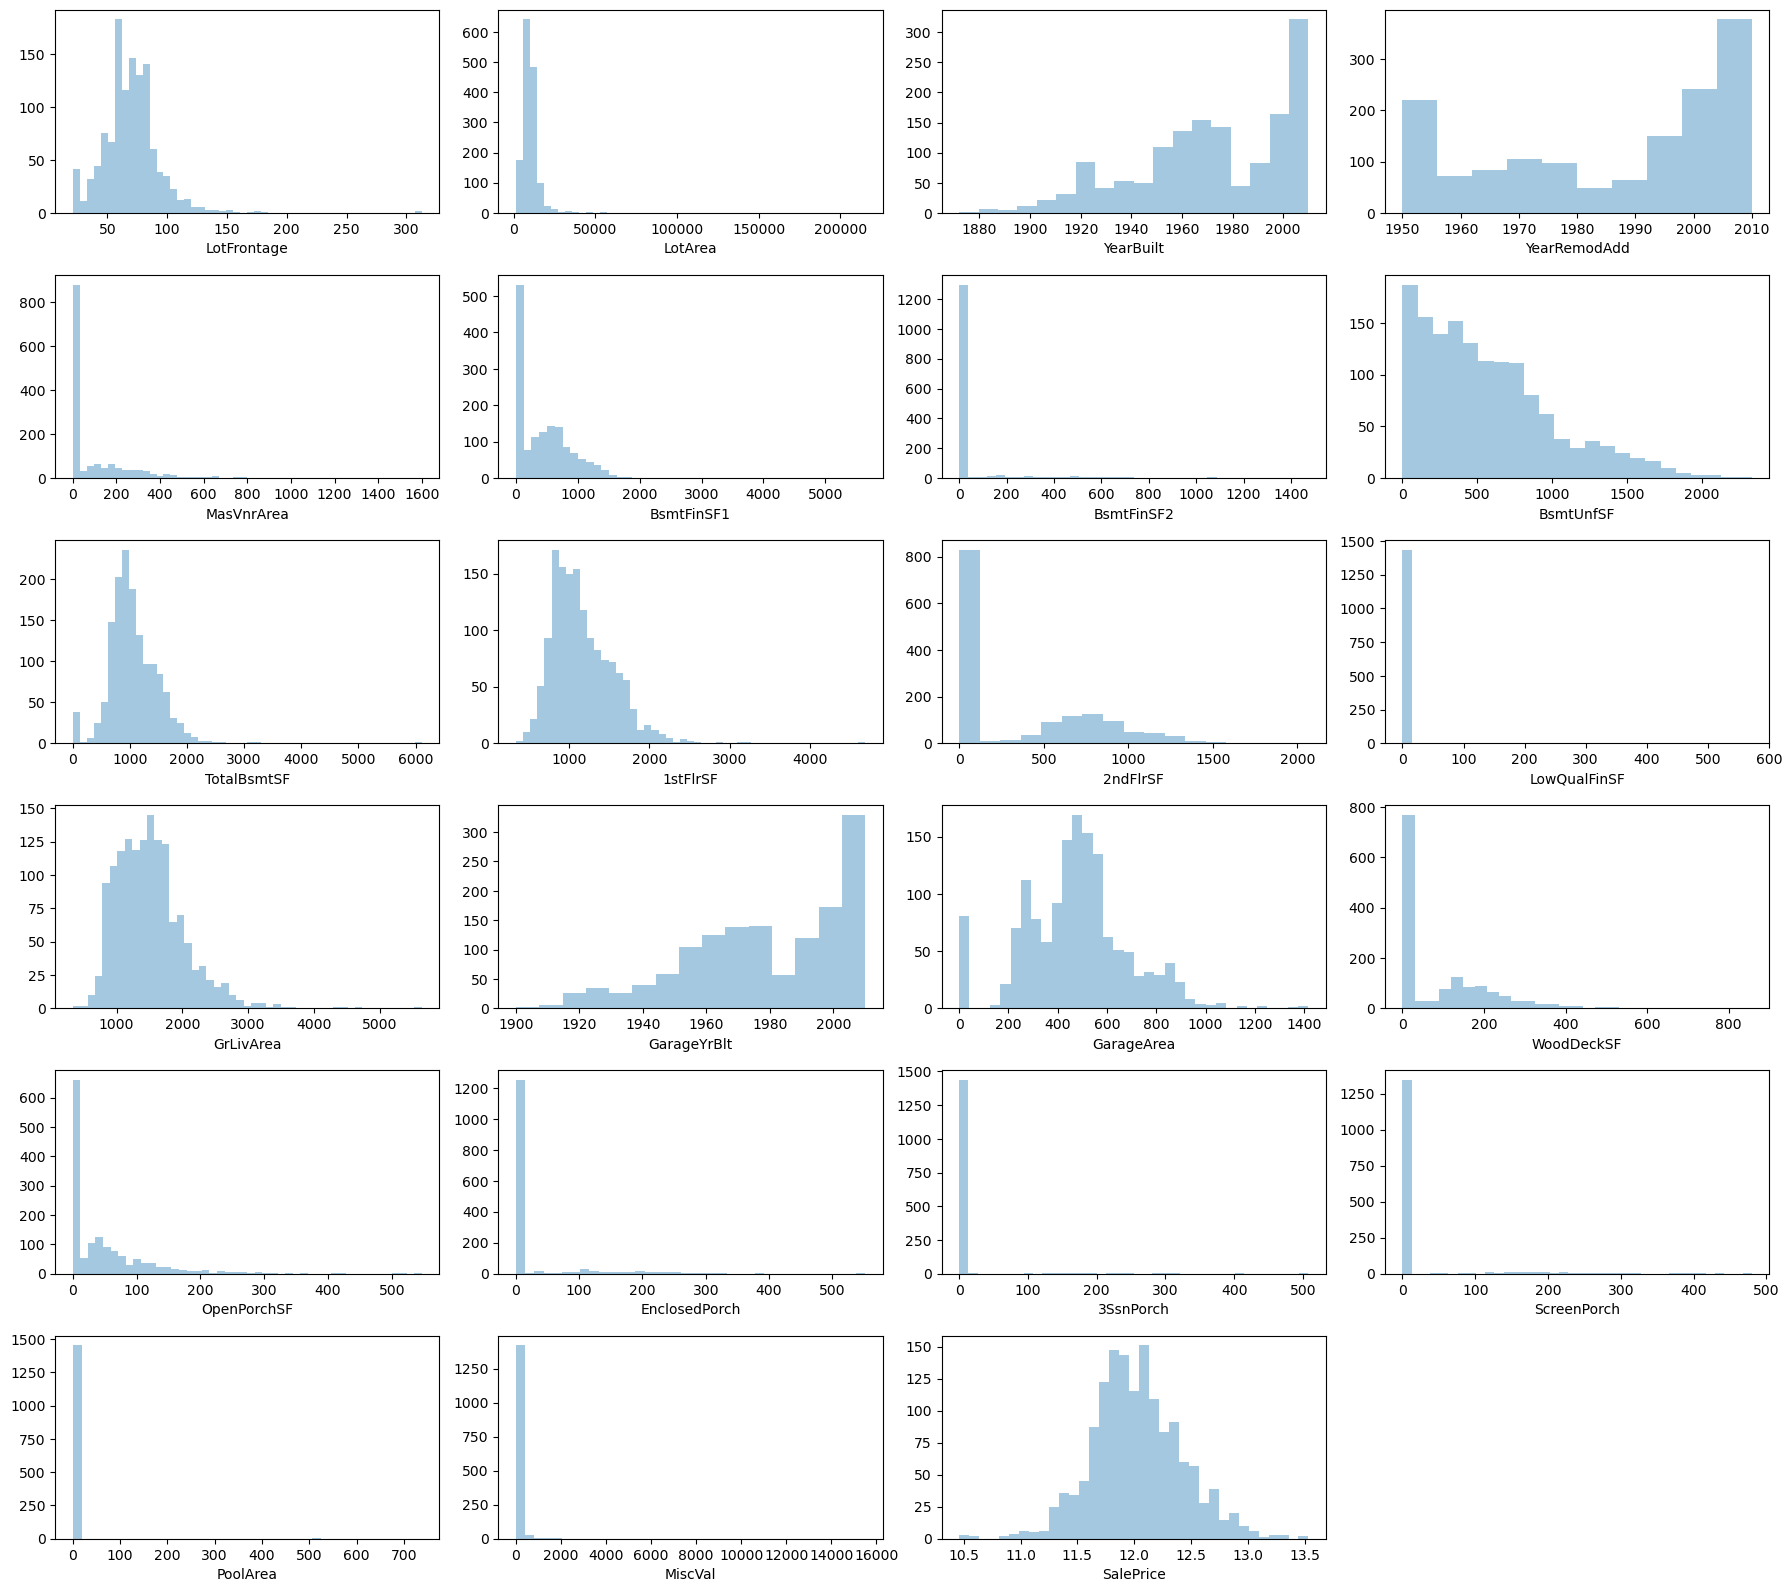

In [ ]:
fig = plt.figure(figsize=(18,16))
for index,col in enumerate(numerical_cont[1:]):
    plt.subplot(6,4,index+1)
    sns.distplot(df_train.loc[:,col].dropna(), kde=False)
fig.tight_layout(pad=1.0)

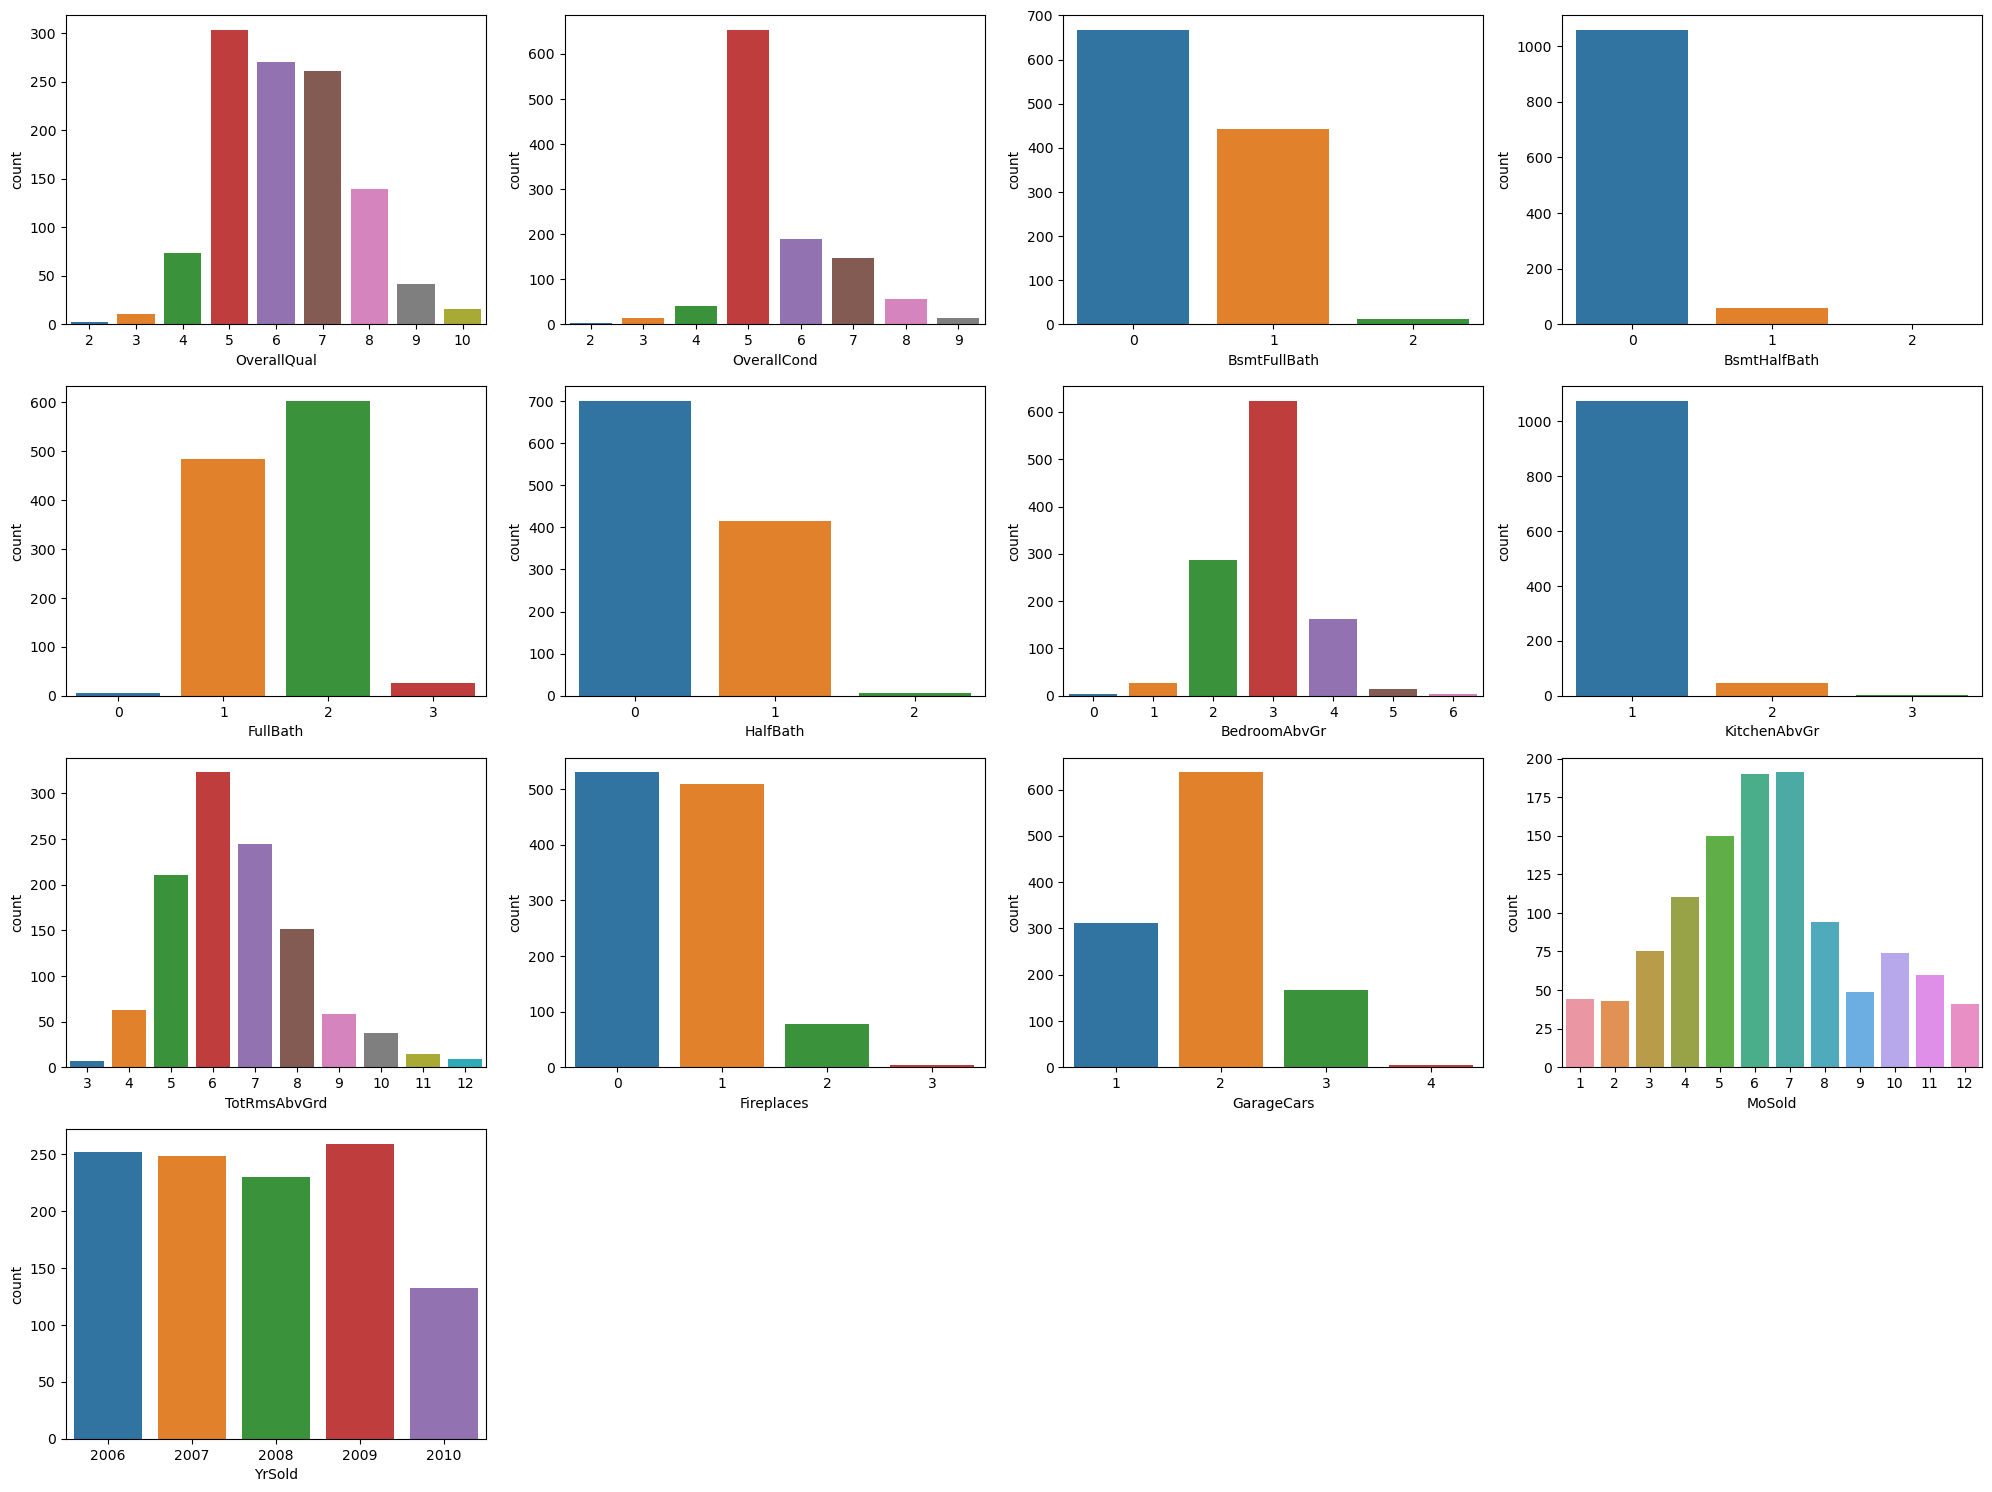

In [ ]:
fig = plt.figure(figsize=(20,15))
for index,col in enumerate(numerical_disc):
    plt.subplot(4,4,index+1)
    sns.countplot(x=col, data=df_train[numerical].dropna())
fig.tight_layout(pad=1.0)

# Part 2: Data processing

## 2.1 Removing redundant features

### 2.1.1 Looking at outliers

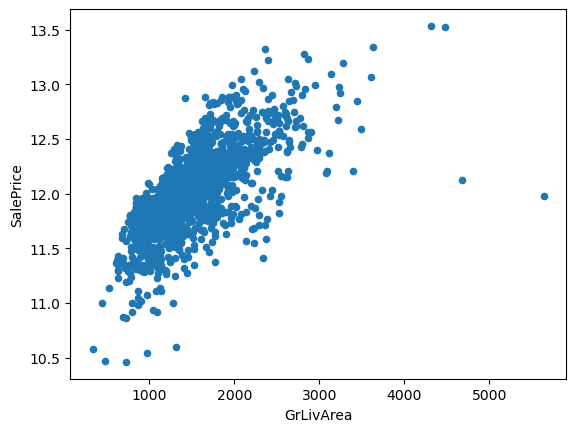

In [ ]:
#bivariate analysis saleprice/grlivarea to remove outliers
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice');

In [ ]:
#df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
#df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
#df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

In [ ]:
#Optional Deleting outliers
#df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)

### 2.1.2 Removing highly correlated features

In [ ]:
#concatenate train and test datasets, preprocess, and then divide them again
y_train = df_train['SalePrice']
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [ ]:
# #remove the highly correlated features to avoid the problem of multicollinearity
# all_data.drop(['GarageYrBlt','TotRmsAbvGrd','1stFlrSF','GarageCars'], axis=1, inplace=True)

### 2.1.3 Removing features that have mostly just 1 value

In [ ]:
#Categorical Features with almost 100% of the same value:  ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', "SaleType", "Electrical", "Functional" ]']
#Numerical Features with almost 100% of the same value:  ['LowQualFinSF', '3SsnPorch', 'PoolArea', 'MiscVal', 'BsmtFinSF1', 'BsmtFinSF2']
all_data.drop(['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'LowQualFinSF', 
               '3SsnPorch', 'PoolArea', 'MiscVal', "SaleType", "Electrical", "Functional", 'BsmtFinSF1', 'BsmtFinSF2'], axis=1, inplace=True)

### 2.1.4 Removing features with a lot of missing values

In [ ]:
#missing data
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageFinish,159,5.447071
GarageCond,159,5.447071
GarageQual,159,5.447071
GarageType,157,5.378554


In [ ]:
#drop columns
all_data.drop((missing_data[missing_data['Total'] > 400]).index, axis=1, inplace=True)
all_data.isnull().sum().sort_values(ascending=False)

GarageCond       159
GarageQual       159
GarageFinish     159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
BsmtFullBath       2
Exterior1st        1
Exterior2nd        1
GarageArea         1
TotalBsmtSF        1
BsmtUnfSF          1
KitchenQual        1
EnclosedPorch      0
YrSold             0
FullBath           0
MoSold             0
ScreenPorch        0
Fireplaces         0
OpenPorchSF        0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
PavedDrive         0
GrLivArea          0
WoodDeckSF         0
MSSubClass         0
2ndFlrSF           0
HouseStyle         0
LotArea            0
LotShape           0
LandContour        0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
BldgType           0
OverallQual        0
CentralAir         0
OverallCond        0
YearBuilt    

## 2.2 Filling missing values

In [ ]:
#numerical
numeric_missed = ['BsmtUnfSF',
                  'TotalBsmtSF',
                  'BsmtFullBath',
                  'BsmtHalfBath',
                  'GarageArea',
                  'MasVnrArea']

for feature in numeric_missed:
    all_data[feature] = all_data[feature].fillna(all_data[feature].mean())

In [ ]:
#categorical
cols = ["MasVnrType", "MSZoning", "Exterior1st", "Exterior2nd"]
all_data[cols] = all_data.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.mode()[0]))

cat = ['GarageType','GarageFinish','BsmtFinType2','BsmtExposure','BsmtFinType1', 
       'GarageCond','GarageQual','BsmtCond','BsmtQual',"KitchenQual",
       "HeatingQC",'ExterQual','ExterCond']

all_data[cat] = all_data[cat].fillna("NA")

In [ ]:
all_data.isnull().sum().max()

0

## 2.3 Converting categorical to numerical

In [ ]:
cat_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual',
           'GarageQual','GarageCond', 'BsmtFinType2','BsmtFinType1', 'BsmtExposure', 'GarageFinish']
#cat_col = ['GarageQual','GarageCond', 'BsmtFinType2','BsmtFinType1', 'BsmtExposure', 'GarageFinish']
cat_feature_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0,
                   'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0,
                   'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0,
                   'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1, 'Fin': 4, 'RFn': 2, 'Unf': 1, 'NA': 0}

for col in cat_col:
    all_data[col] = all_data[col].map(cat_feature_map)

In [ ]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

In [ ]:
all_data = pd.get_dummies(all_data)

# 3 Modeling

In [ ]:
#Split back into train-set set
df_train = all_data.loc[df_train.index]
y_train = y_train.loc[df_train.index]
df_test = all_data.loc[df_test.index]

### 3.1 Scaling of Data

In [ ]:
from sklearn.preprocessing import RobustScaler

cols = df_train.select_dtypes(np.number).columns
transformer = RobustScaler().fit(df_train[cols])
df_train[cols] = transformer.transform(df_train[cols])
df_test[cols] = transformer.transform(df_test[cols])

In [ ]:
#Split into train-validation set
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

X_train, X_val, y_train, y_val = train_test_split(df_train, y_train, test_size=0.2, random_state=1000)


### 3.2 Linear Regression, KNN, DecisionTree, Random Forest, XGB, LGB, CatBoost

In [ ]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

print("TRAIN")
y_pred = model_lr.predict(X_train)
print(f"RMSE:       {mean_squared_error(y_train, y_pred) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_train+1, y_pred+1)}")
print("TEST")
y_pred_LR = model_lr.predict(X_val)
print(f"RMSE:       {mean_squared_error(y_val, y_pred_LR) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_val+1, y_pred_LR+1)}")


NameError: ignored

In [ ]:
dir(y_pred_LR)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors = 5)
model.fit(X_train, y_train)

print("TRAIN")
y_pred = model.predict(X_train)
print(f"RMSE:       {mean_squared_error(y_train, y_pred) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_train+1, y_pred+1)}")
print("TEST")
y_pred_KNN = model.predict(X_val)
print(f"RMSE:       {mean_squared_error(y_val, y_pred_KNN) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_val+1, y_pred_KNN+1)}")

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
DTR = DecisionTreeRegressor(max_depth=5)
DTR.fit(X_train, y_train)

print("TRAIN")
y_pred = DTR.predict(X_train)
print(f"RMSE:       {mean_squared_error(y_train, y_pred) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_train+1, y_pred+1)}")
print("TEST")
y_pred = DTR.predict(X_val)
print(f"RMSE:       {mean_squared_error(y_val, y_pred) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_val+1, y_pred+1)}")

grid_DTR = GridSearchCV(
            DecisionTreeRegressor(),               
            param_grid = {                          
                'max_depth': range(1, 8),
                'min_samples_leaf': range(1, 8),
            },
            scoring = 'neg_mean_absolute_error',  
            cv = 3,                                 
            n_jobs = -1,                            
            return_train_score = True,              
            verbose = 5,                            
        )
grid_DTR.fit(X_train, y_train)

print("TRAIN")
y_pred = grid_DTR.best_estimator_.predict(X_train)
print(f"RMSE:       {mean_squared_error(y_train, y_pred) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_train+1, y_pred+1)}")
print("TEST")
y_pred_DTR = grid_DTR.best_estimator_.predict(X_val)
print(f"RMSE:       {mean_squared_error(y_val, y_pred_DTR) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_val+1, y_pred_DTR+1)}")

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor()
RFR.fit(X_train, y_train)

print("TRAIN")
y_pred = RFR.predict(X_train)
print(f"RMSE:       {mean_squared_error(y_train, y_pred) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_train+1, y_pred+1)}")
print("TEST")
y_pred = RFR.predict(X_val)
print(f"RMSE:       {mean_squared_error(y_val, y_pred) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_val+1, y_pred+1)}")

grid_RFR = RandomizedSearchCV(
            RandomForestRegressor(),                
            param_distributions = {                
                'max_depth': range(6, 20),
                'min_samples_split': range(2, 9),
                'max_features': range(2, 11)
            },
            scoring = 'neg_mean_absolute_error',    
            cv = 3,                                 
            n_jobs = -1,                            
            return_train_score = True,              
            n_iter = 16,                              
            verbose = 5,                            
        )

grid_RFR.fit(X_train, y_train)

print("TRAIN")
y_pred = grid_RFR.best_estimator_.predict(X_train)
print(f"RMSE:       {mean_squared_error(y_train, y_pred) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_train+1, y_pred+1)}")
print("TEST")
y_pred_RFR = grid_RFR.best_estimator_.predict(X_val)
print(f"RMSE:       {mean_squared_error(y_val, y_pred_RFR) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_val+1, y_pred_RFR+1)}")

In [ ]:
# ! pip install lightgbm

In [ ]:
import lightgbm as lgb
LGB_model = lgb.LGBMRegressor(verbose=0)
LGB_model.fit(X_train, y_train)

print("TRAIN")
y_pred = LGB_model.predict(X_train)
print(f"RMSE:       {mean_squared_error(y_train, y_pred) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_train+1, y_pred+1)}")
print("TEST")
y_pred = LGB_model.predict(X_val)
print(f"RMSE:       {mean_squared_error(y_val, y_pred) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_val+1, y_pred+1)}")

grid_LGB = RandomizedSearchCV(
            lgb.LGBMRegressor(verbose=0),          
            param_distributions = {                 
                'max_depth': range(2, 7),
                'lr': np.linspace(0.001, 0.3, 100),
            },
            scoring = 'neg_mean_absolute_error',    
            cv = 3,                                 
            n_jobs = -1,                            
            return_train_score = True,              
            n_iter=30,                              
            verbose = 5,                            
        )

grid_LGB.fit(X_train, y_train)

print("TRAIN")
y_pred = grid_LGB.best_estimator_.predict(X_train)
print(f"RMSE:       {mean_squared_error(y_train, y_pred) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_train+1, y_pred+1)}")
print("TEST")
y_pred_LGB = grid_LGB.best_estimator_.predict(X_val)
print(f"RMSE:       {mean_squared_error(y_val, y_pred_LGB) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_val+1, y_pred_LGB+1)}")

In [ ]:
! pip install xgboost

In [ ]:
import xgboost as XGB

XGB_model = XGB.XGBRegressor()
XGB_model.fit(X_train, y_train)

print("TRAIN")
y_pred = XGB_model.predict(X_train)
print(f"RMSE:       {mean_squared_error(y_train, y_pred) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_train+1, y_pred+1)}")
print("TEST")
y_pred = XGB_model.predict(X_val)
print(f"RMSE:       {mean_squared_error(y_val, y_pred) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_val+1, y_pred+1)}")

grid_XGB = RandomizedSearchCV(
            XGB.XGBRegressor(verbose=0),          #
            param_distributions = {                 
                'max_depth': range(2, 7),
                'lr': np.linspace(0.001, 0.3, 100),
            },
            scoring = 'neg_mean_absolute_error',    
            cv = 3,                                 
            n_jobs = -1,                            
            return_train_score = True,              
            n_iter=30,                              
            verbose = 5,                            
        )

grid_XGB.fit(X_train, y_train)

print("TRAIN")
y_pred = grid_XGB.best_estimator_.predict(X_train)
print(f"RMSE:       {mean_squared_error(y_train, y_pred) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_train+1, y_pred+1)}")
print("TEST")
y_pred_XGB = grid_XGB.best_estimator_.predict(X_val)
print(f"RMSE:       {mean_squared_error(y_val, y_pred_XGB) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_val+1, y_pred_XGB+1)}")

In [ ]:
import catboost as cb

CB_model = cb.CatBoostRegressor(verbose=0)
CB_model.fit(X_train, y_train)

print("TRAIN")
y_pred = CB_model.predict(X_train)
print(f"RMSE:       {mean_squared_error(y_train, y_pred) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_train+1, y_pred+1)}")
print("TEST")
y_pred = CB_model.predict(X_val)
print(f"RMSE:       {mean_squared_error(y_val, y_pred) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_val+1, y_pred+1)}")

grid_CB = RandomizedSearchCV(
            cb.CatBoostRegressor(verbose=0),       
            param_distributions = {                 
                'max_depth': range(2, 7),
                'learning_rate': np.linspace(0.001, 0.3, 100),
            },
            scoring = 'neg_mean_absolute_error',    
            cv = 3,                                 
            n_jobs = -1,                            
            return_train_score = True,              
            n_iter=10,                              
            verbose = 5,                           
        )
grid_CB.fit(X_train, y_train)

print("TRAIN")
y_pred = grid_CB.best_estimator_.predict(X_train)
print(f"RMSE:       {mean_squared_error(y_train, y_pred) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_train+1, y_pred+1)}")
print("TEST")
y_pred_CB = grid_CB.best_estimator_.predict(X_val)
print(f"RMSE:       {mean_squared_error(y_val, y_pred_CB) ** 0.5}")
print(f"MAPE:      {mean_absolute_percentage_error(y_val+1, y_pred_CB+1)}")

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
model_performances = pd.DataFrame({
    "Model" : ["LineRegression", "KNN", "DecisionTree", "RandomForest", "XGBoost", "LGBM", "CatBoost"],
    "RMSE" : [mean_squared_error(y_val, y_pred_LR) ** 0.5, mean_squared_error(y_val, y_pred_KNN) ** 0.5, mean_squared_error(y_val, y_pred_DTR) ** 0.5, \
              mean_squared_error(y_val, y_pred_RFR) ** 0.5, mean_squared_error(y_val, y_pred_XGB) ** 0.5, mean_squared_error(y_val, y_pred_LGB) ** 0.5, \
              mean_squared_error(y_val, y_pred_CB) ** 0.5],
    "MAPE" : [mean_absolute_error(y_val, y_pred_LR), mean_absolute_error(y_val, y_pred_KNN),\
              mean_absolute_error(y_val, y_pred_DTR),mean_absolute_error(y_val, y_pred_RFR), \
              mean_absolute_error(y_val, y_pred_XGB),mean_absolute_error(y_val, y_pred_LGB), \
              mean_absolute_error(y_val, y_pred_CB)],
    "R2" : [r2_score(y_val, y_pred_LR), r2_score(y_val, y_pred_KNN),\
              r2_score(y_val, y_pred_DTR),r2_score(y_val, y_pred_RFR), \
              r2_score(y_val, y_pred_XGB),r2_score(y_val, y_pred_LGB), \
              r2_score(y_val, y_pred_CB)]
})

model_performances